In [0]:
COLAB = True # NOTE change me if not running on Colab :D

In [107]:
if COLAB:
    print("||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
    print("vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv")
    print("                                Hey!                                ")
    print("        Don't forget Google Drive's authorization code below        ")
    print("                                 ;)                                 ")
    print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
    print("||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
                                Hey!                                
        Don't forget Google Drive's authorization code below        
                                 ;)                                 
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


## Importing libs

In [0]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
%matplotlib inline
sns.set() # apply the seaborn defaults to plotted figures (e.g. theme, scaling, color palette), instead of matplotlib's

In [5]:
if COLAB:
    try:
        # Colab only
        %tensorflow_version 2.x
    except Exception:
        pass

TensorFlow 2.x selected.


In [6]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.0.0


In [0]:
import warnings
from time import time, strftime

In [8]:
strftime('%X')

'15:05:03'

## Preparing the Fashion-MNIST dataset
[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) is a dataset of Zalando’s article images, consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28×28 grayscale image, associated with a label from 10 classes.

**NOTE:** you should have the .csv files in the directory listed below

In [9]:
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [10]:
# confirm that you have fashion-mnist_train.csv and fashion-mnist_test.csv (unzipped)
if COLAB:
    PATH_TO_DATA = os.path.join("drive", "My Drive", "unicamp", "%ic", "mc886", "fashion-mnist-dataset")
    !ls drive/My\ Drive/unicamp/%ic/mc886/fashion-mnist-dataset/
else:
    PATH_TO_DATA = os.path.join("..", "fashion-mnist-dataset")
    !ls ../fashion-mnist-dataset/

fashion-mnist_test.csv	fashion-mnist_train.csv  README.txt


In [0]:
# the datasets have the label on the first column and the image pixels on the following 784
train_dataset_csv = pd.read_csv(os.path.join(PATH_TO_DATA, "fashion-mnist_train.csv"), delimiter=',')
test_dataset_csv = pd.read_csv(os.path.join(PATH_TO_DATA, "fashion-mnist_test.csv"), delimiter=',')

In [0]:
IMG_WIDTH = IMG_HEIGHT = 28
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH) # grayscale images
IMG_FLAT_SHAPE = (IMG_HEIGHT*IMG_WIDTH, )

CLASS_NAME = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
CLASS_COUNT = len(CLASS_NAME)

## Split train into train + validation

In [0]:
# random seed for splitting the data deterministically
RANDOM_SEED = 886
np.random.seed(RANDOM_SEED)

In [14]:
from sklearn.model_selection import train_test_split

train_dataset, validation_dataset = train_test_split(train_dataset_csv, train_size=0.8, shuffle=True, random_state=RANDOM_SEED)
print(f"train:      {train_dataset.shape}") # 80%
print(f"validation: {validation_dataset.shape}") # 20%

test_dataset = test_dataset_csv
print(f"test:       {test_dataset.shape}")

train:      (48000, 785)
validation: (12000, 785)
test:       (10000, 785)


## Separate labels and images

In [15]:
ys_train = train_dataset["label"].values
ys_val   = validation_dataset["label"].values
ys_test  = test_dataset["label"].values

print(ys_train.shape, "min:", ys_train.min(), "max:", ys_train.max())
print(ys_val.shape,   "min:", ys_val.min(),   "max:", ys_val.max())
print(ys_test.shape,  "min:", ys_test.min(),  "max:", ys_test.max())

(48000,) min: 0 max: 9
(12000,) min: 0 max: 9
(10000,) min: 0 max: 9


In [16]:
xs_train = train_dataset.loc[:, train_dataset.columns != "label"].values
xs_val   = validation_dataset.loc[:, validation_dataset.columns != "label"].values
xs_test  = test_dataset.loc[:, test_dataset.columns != "label"].values

print(xs_train.shape, "min:", xs_train.min(), "max:", xs_train.max())
print(xs_val.shape,   "min:", xs_val.min(),   "max:", xs_val.max())
print(xs_test.shape,  "min:", xs_test.min(),  "max:", xs_test.max())

(48000, 784) min: 0 max: 255
(12000, 784) min: 0 max: 255
(10000, 784) min: 0 max: 255


In [0]:
def each_count(array):
    count = np.bincount(array)
    nonzero_count = np.nonzero(count)[0]
    return zip(nonzero_count, count[nonzero_count])

In [18]:
class_count_train = list(each_count(ys_train))
class_count_val   = list(each_count(ys_val))
class_count_test  = list(each_count(ys_test))
print("              Train         Validation    Test")
for label in range(CLASS_COUNT):
    print(f"{(CLASS_NAME[label] + ':'):<12}  "
          f"{class_count_train[label][1]} ({class_count_train[label][1] / ys_train.shape[0]:.2f}%)  "
          f"{class_count_val[label][1]} ({class_count_val[label][1] / ys_val.shape[0]:.2f}%)  "
          f"{class_count_test[label][1]} ({class_count_test[label][1] / ys_test.shape[0]:.2f}%)")

              Train         Validation    Test
T-shirt/top:  4863 (0.10%)  1137 (0.09%)  1000 (0.10%)
Trouser:      4795 (0.10%)  1205 (0.10%)  1000 (0.10%)
Pullover:     4817 (0.10%)  1183 (0.10%)  1000 (0.10%)
Dress:        4770 (0.10%)  1230 (0.10%)  1000 (0.10%)
Coat:         4820 (0.10%)  1180 (0.10%)  1000 (0.10%)
Sandal:       4769 (0.10%)  1231 (0.10%)  1000 (0.10%)
Shirt:        4771 (0.10%)  1229 (0.10%)  1000 (0.10%)
Sneaker:      4764 (0.10%)  1236 (0.10%)  1000 (0.10%)
Bag:          4778 (0.10%)  1222 (0.10%)  1000 (0.10%)
Ankle boot:   4853 (0.10%)  1147 (0.10%)  1000 (0.10%)


## Normalize images and one-hot encode labels

In [0]:
xs_train = xs_train.astype('float32') / 255.0
xs_val   = xs_val.astype('float32')   / 255.0
xs_test  = xs_test.astype('float32')  / 255.0

**Let's forget about the test set for now..** just assume it doesn't exist (but don't worry, we'll come back to it at the end).

In [20]:
print(f"xs_train: mean={xs_train.mean():>8.4f}, stddev={xs_train.std():>7.4f}")

# NOTE that we must use stats from train data to normalize the val and test sets aswell
mean, std = xs_train.mean(), xs_train.std()
X_train = (xs_train - mean) / std

print(f"X_train:  mean={X_train.mean():>8.4f}, stddev={X_train.std():>7.4f}")

xs_train: mean=  0.2862, stddev= 0.3529
X_train:  mean=  0.0000, stddev= 1.0000


In [21]:
X_val = (xs_val - mean) / std
print(f"xs_val: mean={xs_val.mean():>8.4f}, stddev={xs_val.std():>7.4f}")
print(f"X_val:  mean={X_val.mean():>8.4f}, stddev={X_val.std():>7.4f}") # mean should be close to 0 and stddev close to 1

xs_val: mean=  0.2858, stddev= 0.3526
X_val:  mean= -0.0011, stddev= 0.9992


In [0]:
def onehot_encode(ys):
    n_examples, *_ = ys.shape
    onehot = np.zeros(shape=(n_examples, CLASS_COUNT))
    onehot[np.arange(n_examples), ys] = 1
    return onehot

In [23]:
Y_train = onehot_encode(ys_train)
print(ys_train.shape, Y_train.shape)

(48000,) (48000, 10)


In [24]:
Y_val = onehot_encode(ys_val)
print(ys_val.shape, Y_val.shape)

(12000,) (12000, 10)


_obs.:_ `Y_foo` is only a one-hot encoded version of `ys_foo` (so we use `ys_foo` in some places below, to avoid calling `np.argmax`)

## Add helper functions

In [0]:
def plot_history(history, model=None, n_epochs=None, batch_size=None, title_prefix=None):
    plot_title = ("" if title_prefix is None else (title_prefix + "\n")) + "Train history"
    info = []
    if n_epochs is not None:
        info.append(f"{n_epochs} epochs")
    if batch_size is not None:
        info.append(f"{batch_size} batch size")
    if model is not None:
        info.append(f"{model.optimizer.get_config()['name']} optimizer")
    if len(info) > 0:
        plot_title += f" ({', '.join(info)})"
    
    # leave only "loss" and "val_loss" for plotting
    loss_data = pd.DataFrame({k: v for k, v in history.items() if (k == "loss" or k == "val_loss")})
    loss_data.index += 1 # start counting the epochs at 1, not 0
    lineplot = sns.lineplot(data=loss_data)
    lineplot.set_title(plot_title)
    lineplot.set_xlabel("epoch")
    lineplot.set_ylabel("Loss" + f" ({model.loss})" if model is not None else "")
    plt.show()

    # leave only "accuracy" and "val_accuracy" for plotting
    acc_data = pd.DataFrame({k: v for k, v in history.items() if (k == "accuracy" or k == "val_accuracy")})
    acc_data.index += 1 # start counting the epochs at 1, not 0
    lineplot = sns.lineplot(data=acc_data)
    lineplot.set_title(plot_title)
    lineplot.set_xlabel("epoch")
    lineplot.set_ylabel("Accuracy")
    plt.show()

In [0]:
def plot_image_with_prediction(xs, ys, ys_pred, num_rows=5, num_cols=3):
    # ref.: https://www.tensorflow.org/tutorials/keras/classification
    
    def plot_image(i, predictions_array, true_label, img):
        true_label, img = true_label[i], img[i]
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img.reshape(IMG_SHAPE), cmap=plt.cm.binary)
        predicted_label = np.argmax(predictions_array)
        color = 'blue' if predicted_label == true_label else 'red'
        plt.xlabel("{} {:2.0f}% ({})".format(CLASS_NAME[predicted_label],
                                             100*np.max(predictions_array),
                                             CLASS_NAME[true_label]),
                                             color=color)

    def plot_value_array(i, predictions_array, true_label):
        true_label = true_label[i]
        plt.grid(False)
        plt.xticks(range(10))
        plt.yticks([])
        thisplot = plt.bar(range(10), predictions_array, color="#777777")
        plt.ylim([0, 1])
        predicted_label = np.argmax(predictions_array)
        thisplot[predicted_label].set_color('red')
        thisplot[true_label].set_color('blue')
    
    # plot the first few test images, their predicted labels, and the true labels
    # color correct predictions in blue and incorrect predictions in red    
    num_images = num_rows * num_cols
    plt.figure(figsize=(4 * num_cols, 2 * num_rows))
    for i in range(num_images):
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
        plot_image(i, ys_pred[i], ys, xs)
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
        plot_value_array(i, ys_pred[i], ys)
    plt.tight_layout()
    plt.show()

In [0]:
from sklearn.metrics import confusion_matrix, f1_score

In [0]:
def print_cm(ys, ys_pred, class_names, figsize=(10, 9), fontsize=12):
    #cm = confusion_matrix(ys, ys_pred)
    #df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    cm = np.flip(confusion_matrix(ys, ys_pred), axis=0)
    df_cm = pd.DataFrame(cm, index=class_names[::-1], columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    heatmap.set_ylim(*heatmap.get_xlim())
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## 1. Baseline
Explore Neural Networks with Fashion-MNIST. What is the accuracy? Describe your Neural Network architecture.

In [0]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Reshape
from tensorflow.keras.regularizers import l1, l2

In [0]:
MAX_EPOCHS = 64
BATCH_SIZE = 512
TF_VERBOSE = 1 # 0 = silent, 1 = progress bar, 2 = one line per epoch

In [0]:
def train(model, X_train, Y_train, X_val, Y_val, n_epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, 
          min_delta=0.003, patience=3, early_stopping=True, plot_title=None, plot=True):
    best_model_path = os.path.join("models", f"best_model_{model.name}.h5")
    if not os.path.exists(os.path.dirname(best_model_path)):
        os.makedirs(os.path.dirname(best_model_path))
    
    callbacks = ([keras.callbacks.ModelCheckpoint(monitor='val_loss', filepath=best_model_path, save_best_only=True)]
                 if not early_stopping else
                 [keras.callbacks.ModelCheckpoint(monitor='val_loss', filepath=best_model_path, save_best_only=True),
                  keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=min_delta, patience=patience)])
    
    print("Starting to train...")
    start = time()
    hist = model.fit(
        x=X_train, y=Y_train,
        validation_data=(X_val, Y_val),
        epochs=n_epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=TF_VERBOSE
    ).history
    end = time()
    print(f"\nDone.\nTraining took {(end - start):.2f}s")
    
    if os.path.exists(best_model_path):
        model = keras.models.load_model(best_model_path)
    
    if plot:
        plot_history(hist, model, n_epochs, batch_size, plot_title)
    
    return hist, model

### 1.1. MLP

In [0]:
model = keras.Sequential([
    Input(IMG_FLAT_SHAPE), # 28 * 28 = 784 pixels
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
], "MLP_baseline")

In [0]:
# NOTE use 'categorical_crossentropy' since `labels` is a one-hot encoded vector
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [34]:
model.summary()

Model: "MLP_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.optimizer.get_config()

{'amsgrad': False,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'decay': 0.0,
 'epsilon': 1e-07,
 'learning_rate': 0.001,
 'name': 'Adam'}

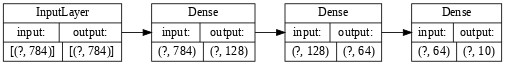

In [124]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, rankdir='LR', dpi=60)

In [36]:
strftime('%X')

'15:05:50'

Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 2s 50us/sample - loss: 0.6761 - accuracy: 0.7720 - val_loss: 0.4700 - val_accuracy: 0.8347
Epoch 2/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.4262 - accuracy: 0.8533 - val_loss: 0.4140 - val_accuracy: 0.8583
Epoch 3/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.3809 - accuracy: 0.8685 - val_loss: 0.3835 - val_accuracy: 0.8650
Epoch 4/64
48000/48000 [==============================] - 1s 13us/sample - loss: 0.3588 - accuracy: 0.8760 - val_loss: 0.3647 - val_accuracy: 0.8702
Epoch 5/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.3321 - accuracy: 0.8842 - val_loss: 0.3499 - val_accuracy: 0.8777
Epoch 6/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.3184 - accuracy: 0.8901 - val_loss: 0.3545 - val_accuracy: 0.8746
Epoch 7/64
48000/48000 [===========

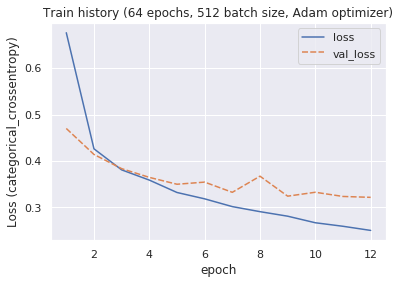

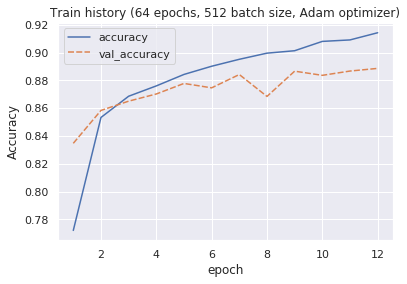

In [37]:
history, best_model = train(model, X_train, Y_train, X_val, Y_val)

In [38]:
strftime('%X')

'15:06:00'

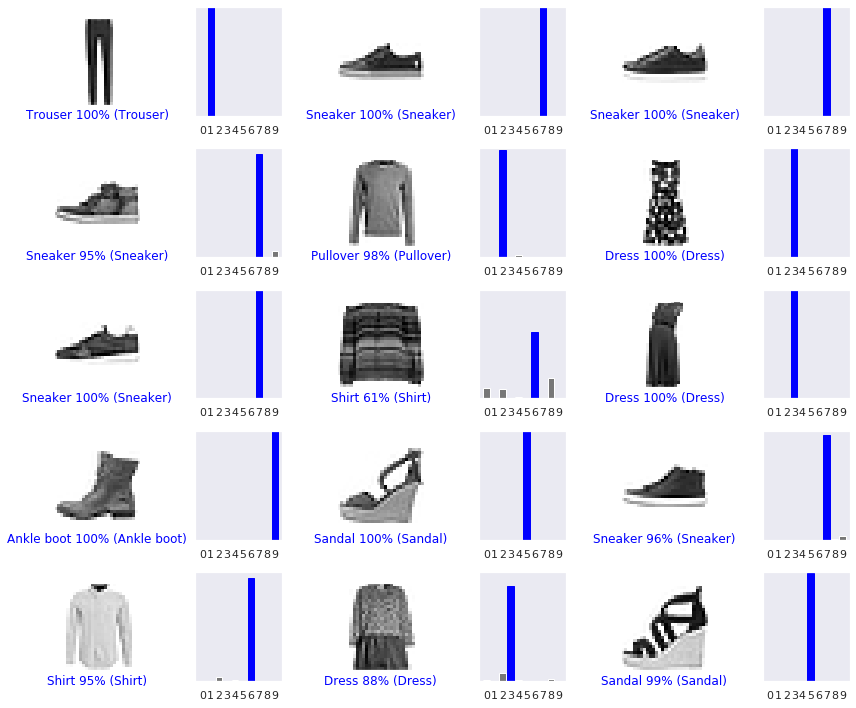

In [39]:
Y_val_pred = best_model.predict(X_val)
plot_image_with_prediction(X_val, ys_val, Y_val_pred)

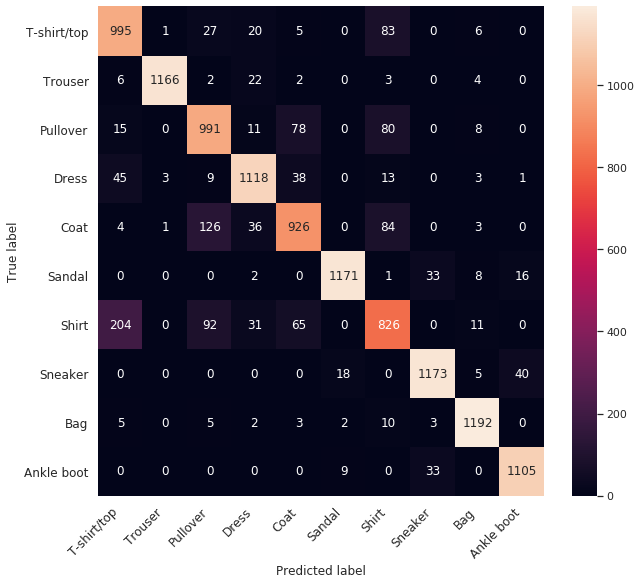

In [40]:
print_cm(ys_val, np.argmax(Y_val_pred, axis=1), CLASS_NAME)

### 1.2. CNN

In [0]:
# obs.: padding='valid' by default (i.e. no padding)
conv_model = keras.Sequential([
    Reshape((28, 28, 1), input_shape=(784,)),
    Conv2D(32, (5, 5), activation='relu', padding='same', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)), # 28x28 -> 14x14 feature map
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)), # 14x14 -> 7x7 feature map
    Flatten(), # 7*7*64 = 3136
    Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
], "CNN_baseline")

In [0]:
conv_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [43]:
conv_model.summary()

Model: "CNN_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [44]:
conv_model.optimizer.get_config()

{'amsgrad': False,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'decay': 0.0,
 'epsilon': 1e-07,
 'learning_rate': 0.001,
 'name': 'Adam'}

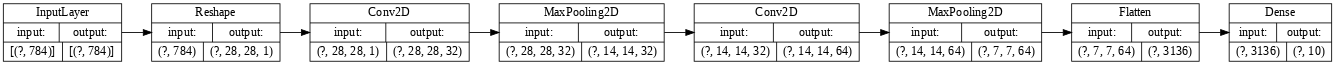

In [125]:
tf.keras.utils.plot_model(conv_model, show_shapes=True, show_layer_names=False, rankdir='LR', dpi=60)

In [45]:
strftime('%X')

'15:06:06'

Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 6s 121us/sample - loss: 0.7245 - accuracy: 0.7581 - val_loss: 0.4555 - val_accuracy: 0.8495
Epoch 2/64
48000/48000 [==============================] - 2s 49us/sample - loss: 0.4294 - accuracy: 0.8564 - val_loss: 0.4028 - val_accuracy: 0.8691
Epoch 3/64
48000/48000 [==============================] - 2s 49us/sample - loss: 0.3859 - accuracy: 0.8717 - val_loss: 0.3642 - val_accuracy: 0.8827
Epoch 4/64
48000/48000 [==============================] - 2s 49us/sample - loss: 0.3555 - accuracy: 0.8840 - val_loss: 0.3592 - val_accuracy: 0.8849
Epoch 5/64
48000/48000 [==============================] - 2s 49us/sample - loss: 0.3311 - accuracy: 0.8923 - val_loss: 0.3342 - val_accuracy: 0.8908
Epoch 6/64
48000/48000 [==============================] - 2s 49us/sample - loss: 0.3155 - accuracy: 0.8971 - val_loss: 0.3409 - val_accuracy: 0.8910
Epoch 7/64
48000/48000 [==========

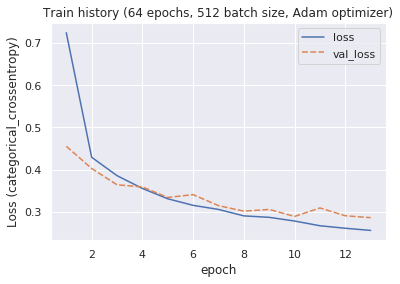

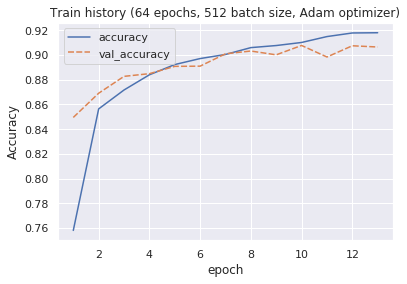

In [46]:
conv_history, best_conv_model = train(conv_model, X_train, Y_train, X_val, Y_val)

In [47]:
strftime('%X')

'15:06:41'

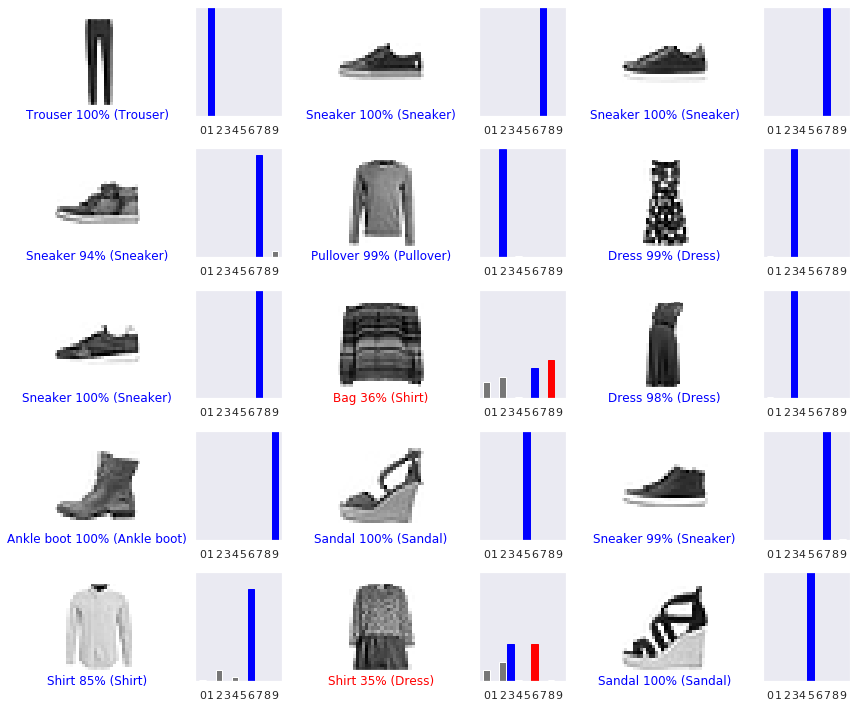

In [48]:
Y_val_conv_pred = best_conv_model.predict(X_val)
plot_image_with_prediction(X_val, ys_val, Y_val_conv_pred)

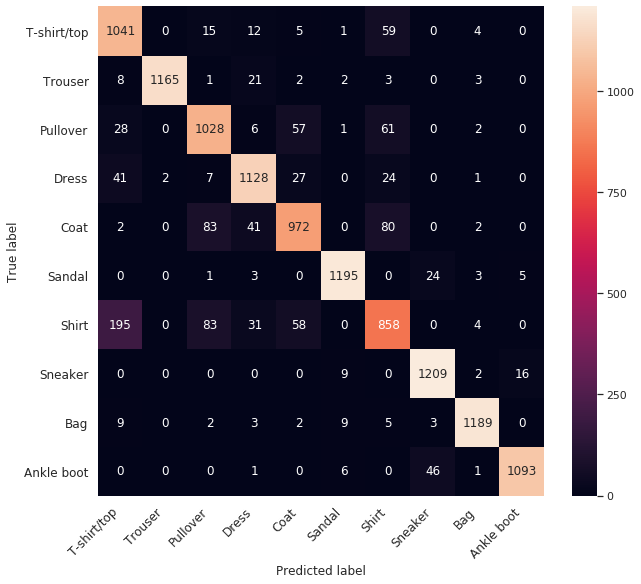

In [49]:
print_cm(ys_val, np.argmax(Y_val_conv_pred, axis=1), CLASS_NAME)

## 2. Using PCA
Re-do the ﬁrst experiment considering the PCA dimensionality reduction. Consider three diﬀerent energies (variance) for reducing the image dimensionality. What are the conclusions when using PCA in this problem? Does the accuracy improve?

In [0]:
from sklearn.decomposition import PCA

In [0]:
def print_info(array, name):
    print(f"{name+':':<9} {array.dtype.name:<7} {str(array.shape):<12} "
          f"| min: {array.min():>5.2f} | max: {array.max():>5.2f} "
          f"| mean: {array.mean():>5.3f} | std: {array.std():>5.3f}")

In [52]:
print_info(X_train, "X_train")
print_info(xs_train, "xs_train")
print_info(Y_train, "Y_train")
print_info(ys_train, "ys_train")

X_train:  float32 (48000, 784) | min: -0.81 | max:  2.02 | mean: 0.000 | std: 1.000
xs_train: float32 (48000, 784) | min:  0.00 | max:  1.00 | mean: 0.286 | std: 0.353
Y_train:  float64 (48000, 10)  | min:  0.00 | max:  1.00 | mean: 0.100 | std: 0.300
ys_train: int64   (48000,)     | min:  0.00 | max:  9.00 | mean: 4.495 | std: 2.879


_As we'll be reducing the amount of features (dimensions) of our input data after applying PCA, it makes more sense to treat it as a vector, instead of as an image.
Thus, we'll use our MLP baseline model instead of our CNN, even though the latter showed better results._

In [0]:
def build_pca_model(min_explained_variance, model_name):
    pca = PCA(min_explained_variance)
    pca.fit(X_train) # fit on train data (and then use it to transform both train and validation)
    print(pca)
    print()
    
    explained_variance = pca.explained_variance_ratio_.sum()
    print(f"{pca.n_components_} principal components → {explained_variance} explained variance")
    print(f"{pca.n_components_} / {X_train.shape[1]} = {(100 * pca.n_components_ / X_train.shape[1]):.2f}% of components used")
    
    model_pca = keras.Sequential([
        Input(shape=(pca.n_components_, )), # number of components used to keep min_explained_variance
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
    ], model_name)
    
    model_pca.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    
    return model_pca, pca

In [0]:
def train_pca_model(model_pca, pca):
    history_pca, best_model_pca = train(model_pca, 
                                        pca.transform(X_train), Y_train, 
                                        pca.transform(X_val), Y_val, 
                                        n_epochs=64, batch_size=512)

    # using ys_val below, instead of np.argmax(Y_val, axis=1), simply for convinence

    Y_val_pca_pred = best_model_pca.predict(pca.transform(X_val))
    plot_image_with_prediction(X_val, ys_val, Y_val_pca_pred)

    print_cm(ys_val, np.argmax(Y_val_pca_pred, axis=1), CLASS_NAME)
    
    return Y_val_pca_pred

### 2.1. 99% explained variance

In [55]:
model_99var, pca_99var = build_pca_model(min_explained_variance=0.99, model_name="MLP_99var")

PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

458 principal components → 0.9900491237640381 explained variance
458 / 784 = 58.42% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 23us/sample - loss: 0.8282 - accuracy: 0.7365 - val_loss: 0.4560 - val_accuracy: 0.8462
Epoch 2/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.3990 - accuracy: 0.8673 - val_loss: 0.3960 - val_accuracy: 0.8663
Epoch 3/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.3379 - accuracy: 0.8872 - val_loss: 0.3708 - val_accuracy: 0.8753
Epoch 4/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.3001 - accuracy: 0.9014 - val_loss: 0.3624 - val_accuracy: 0.8767
Epoch 5/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.2702 - accuracy: 0.9124 - val_loss: 0.3511 - val_accuracy: 0.8808
Epoch 6/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.2454 - accuracy: 0.9221 - val_loss: 0.3467 - val_accuracy: 0.8832
Epoch 7/64
48000/48000 [===========

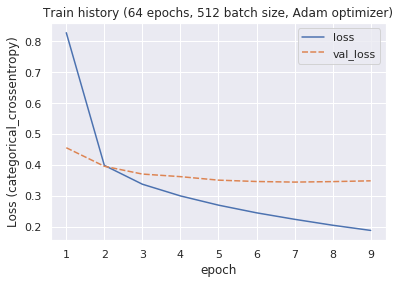

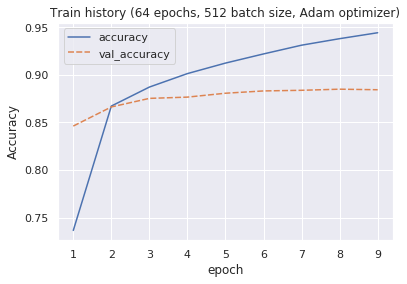

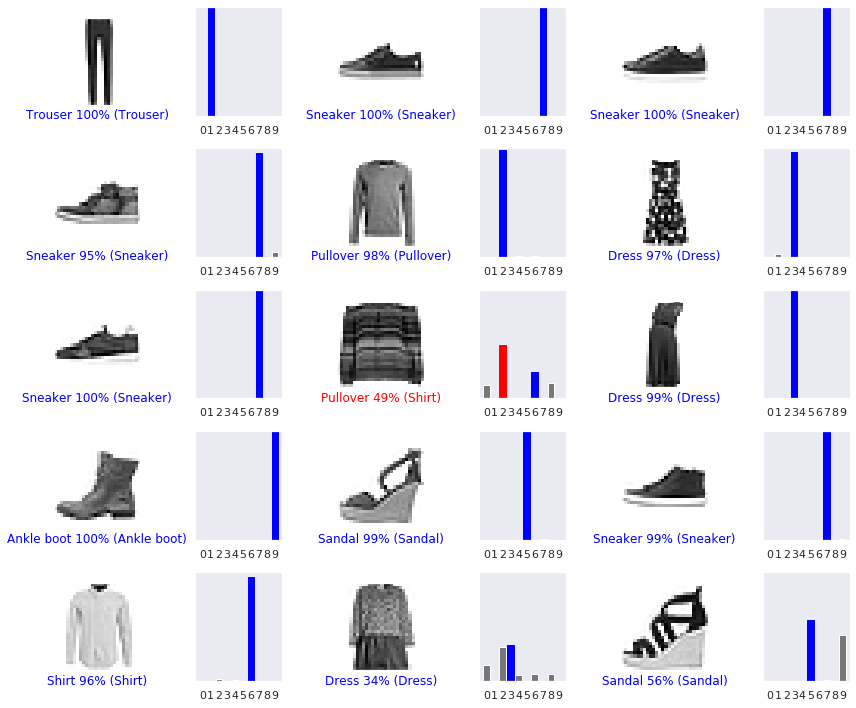

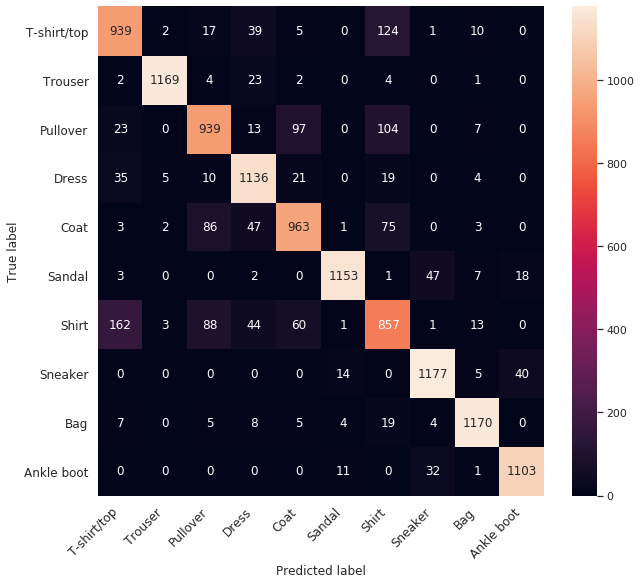

In [56]:
Y_val_99var_pred = train_pca_model(model_99var, pca_99var)

### 2.2. 95% explained variance

In [57]:
model_95var, pca_95var = build_pca_model(min_explained_variance=0.95, model_name="MLP_95var")

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

187 principal components → 0.9501577615737915 explained variance
187 / 784 = 23.85% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 23us/sample - loss: 0.8403 - accuracy: 0.7273 - val_loss: 0.4714 - val_accuracy: 0.8395
Epoch 2/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.4197 - accuracy: 0.8576 - val_loss: 0.4044 - val_accuracy: 0.8633
Epoch 3/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.3655 - accuracy: 0.8747 - val_loss: 0.3773 - val_accuracy: 0.8710
Epoch 4/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.3352 - accuracy: 0.8848 - val_loss: 0.3591 - val_accuracy: 0.8763
Epoch 5/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.3111 - accuracy: 0.8945 - val_loss: 0.3514 - val_accuracy: 0.8786
Epoch 6/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.2928 - accuracy: 0.9004 - val_loss: 0.3465 - val_accuracy: 0.8819
Epoch 7/64
48000/48000 [===========

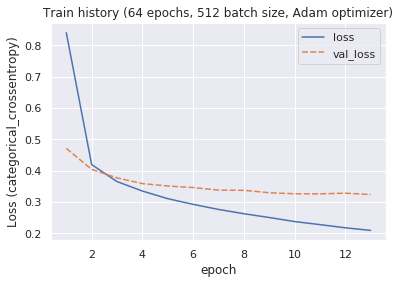

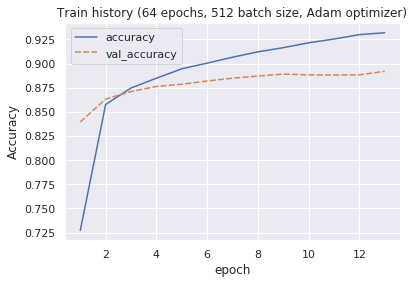

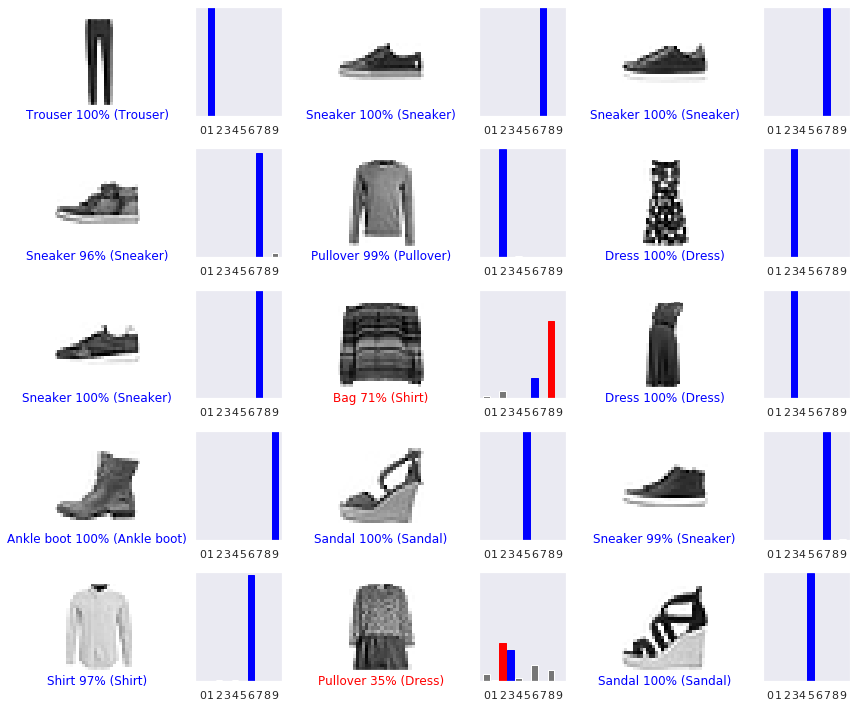

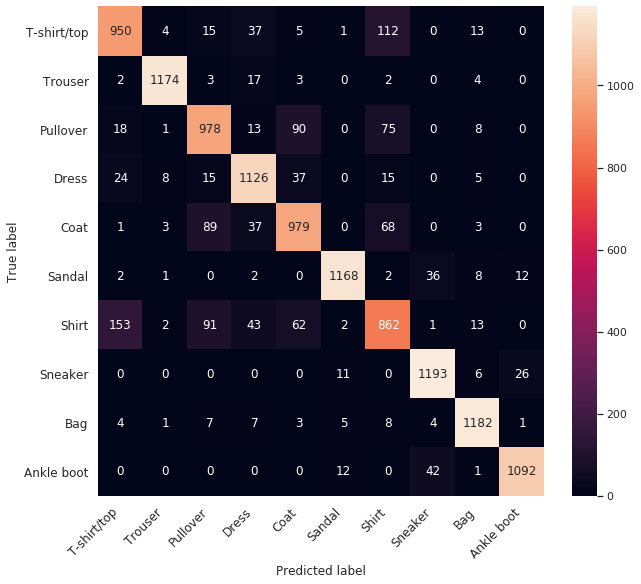

In [58]:
Y_val_95var_pred = train_pca_model(model_95var, pca_95var)

### 2.3. 90% explained variance

In [59]:
model_90var, pca_90var = build_pca_model(min_explained_variance=0.90, model_name="MLP_90var")

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

84 principal components → 0.9006989598274231 explained variance
84 / 784 = 10.71% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 26us/sample - loss: 0.9071 - accuracy: 0.7128 - val_loss: 0.4925 - val_accuracy: 0.8346
Epoch 2/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.4464 - accuracy: 0.8484 - val_loss: 0.4248 - val_accuracy: 0.8582
Epoch 3/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.3942 - accuracy: 0.8663 - val_loss: 0.3996 - val_accuracy: 0.8650
Epoch 4/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.3666 - accuracy: 0.8764 - val_loss: 0.3823 - val_accuracy: 0.8701
Epoch 5/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.3468 - accuracy: 0.8823 - val_loss: 0.3689 - val_accuracy: 0.8727
Epoch 6/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.3308 - accuracy: 0.8881 - val_loss: 0.3654 - val_accuracy: 0.8768
Epoch 7/64
48000/48000 [===========

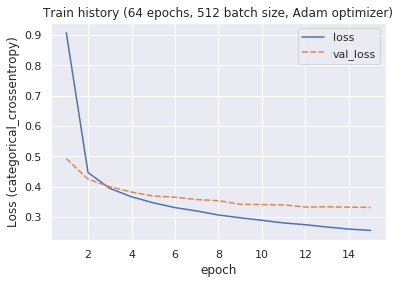

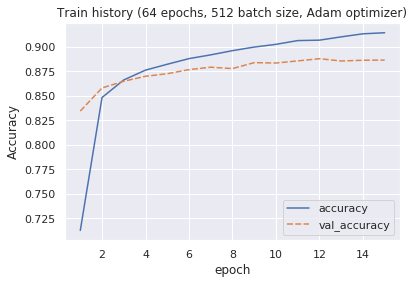

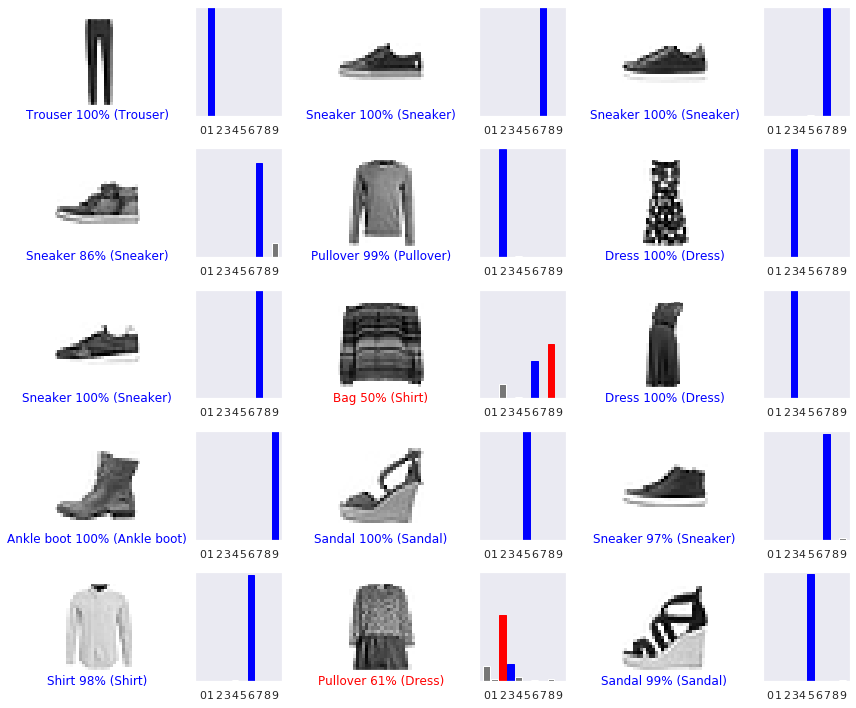

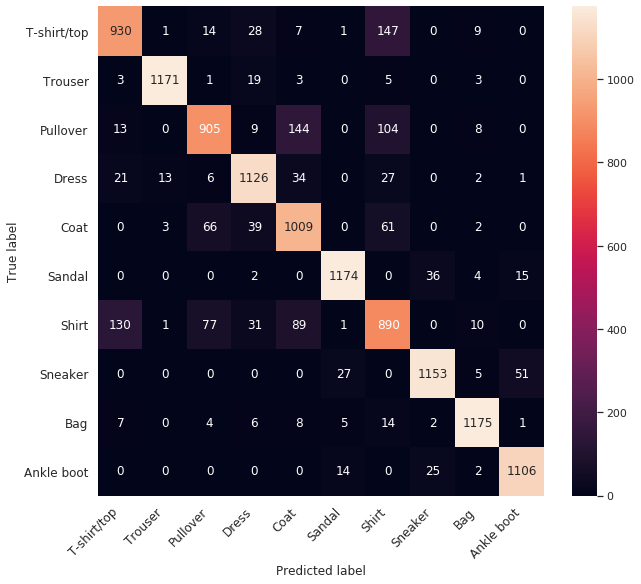

In [60]:
Y_val_90var_pred = train_pca_model(model_90var, pca_90var)

### 2.4. F1-scores

In [0]:
from sklearn.metrics import precision_recall_fscore_support

In [0]:
def print_f1_scores(ys, ys_pred, class_name_dict=CLASS_NAME):
    # ref.: https://github.com/erikperillo/ml-2sem2019/
    def harmonic_mean_of_positive_values(values, eps=1e-18):
        return len(values) / sum(1 / max(v, eps) for v in values)
    
    precision, recall, f1_score, _ = precision_recall_fscore_support(ys, ys_pred)
    print("                       Precision    Recall    F1-score")
    for i, (p, r, f1) in enumerate(zip(precision, recall, f1_score)):
        print(f"Class {i} {f'({class_name_dict[i]}):':<16} {p:.4f}  |  {r:.4f}  |  {f1:.4f}")
    print()
    print(f"Combined F1 score:  {harmonic_mean_of_positive_values(f1_score):.4f}")
    print(f"Combined Precision: {harmonic_mean_of_positive_values(precision):.4f}")
    print(f"Combined Recall:    {harmonic_mean_of_positive_values(recall):.4f}")

In [63]:
# MLP baseline
print_f1_scores(ys_val, np.argmax(Y_val_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.7810  |  0.8751  |  0.8254
Class 1 (Trouser):       0.9957  |  0.9676  |  0.9815
Class 2 (Pullover):      0.7915  |  0.8377  |  0.8140
Class 3 (Dress):         0.9002  |  0.9089  |  0.9045
Class 4 (Coat):          0.8290  |  0.7847  |  0.8063
Class 5 (Sandal):        0.9758  |  0.9513  |  0.9634
Class 6 (Shirt):         0.7509  |  0.6721  |  0.7093
Class 7 (Sneaker):       0.9444  |  0.9490  |  0.9467
Class 8 (Bag):           0.9613  |  0.9755  |  0.9683
Class 9 (Ankle boot):    0.9509  |  0.9634  |  0.9571

Combined F1 score:  0.8782
Combined Precision: 0.8793
Combined Recall:    0.8772


In [64]:
# CNN baseline
print_f1_scores(ys_val, np.argmax(Y_val_conv_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.7863  |  0.9156  |  0.8460
Class 1 (Trouser):       0.9983  |  0.9668  |  0.9823
Class 2 (Pullover):      0.8426  |  0.8690  |  0.8556
Class 3 (Dress):         0.9053  |  0.9171  |  0.9111
Class 4 (Coat):          0.8655  |  0.8237  |  0.8441
Class 5 (Sandal):        0.9771  |  0.9708  |  0.9739
Class 6 (Shirt):         0.7872  |  0.6981  |  0.7400
Class 7 (Sneaker):       0.9431  |  0.9782  |  0.9603
Class 8 (Bag):           0.9818  |  0.9730  |  0.9774
Class 9 (Ankle boot):    0.9811  |  0.9529  |  0.9668

Combined F1 score:  0.8986
Combined Precision: 0.8999
Combined Recall:    0.8974


In [65]:
# 99% explained variance
print_f1_scores(ys_val, np.argmax(Y_val_99var_pred, axis=1), CLASS_NAME) # FIXME why is this worse than 95% ?

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.7998  |  0.8259  |  0.8126
Class 1 (Trouser):       0.9898  |  0.9701  |  0.9799
Class 2 (Pullover):      0.8172  |  0.7937  |  0.8053
Class 3 (Dress):         0.8659  |  0.9236  |  0.8938
Class 4 (Coat):          0.8352  |  0.8161  |  0.8255
Class 5 (Sandal):        0.9738  |  0.9366  |  0.9549
Class 6 (Shirt):         0.7124  |  0.6973  |  0.7048
Class 7 (Sneaker):       0.9326  |  0.9523  |  0.9424
Class 8 (Bag):           0.9582  |  0.9574  |  0.9578
Class 9 (Ankle boot):    0.9500  |  0.9616  |  0.9558

Combined F1 score:  0.8741
Combined Precision: 0.8745
Combined Recall:    0.8737


In [66]:
# 95% explained variance
print_f1_scores(ys_val, np.argmax(Y_val_95var_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8232  |  0.8355  |  0.8293
Class 1 (Trouser):       0.9832  |  0.9743  |  0.9787
Class 2 (Pullover):      0.8164  |  0.8267  |  0.8215
Class 3 (Dress):         0.8783  |  0.9154  |  0.8965
Class 4 (Coat):          0.8304  |  0.8297  |  0.8300
Class 5 (Sandal):        0.9741  |  0.9488  |  0.9613
Class 6 (Shirt):         0.7535  |  0.7014  |  0.7265
Class 7 (Sneaker):       0.9350  |  0.9652  |  0.9498
Class 8 (Bag):           0.9509  |  0.9673  |  0.9590
Class 9 (Ankle boot):    0.9655  |  0.9520  |  0.9587

Combined F1 score:  0.8834
Combined Precision: 0.8842
Combined Recall:    0.8826


In [67]:
# 90% explained variance
print_f1_scores(ys_val, np.argmax(Y_val_90var_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8424  |  0.8179  |  0.8300
Class 1 (Trouser):       0.9849  |  0.9718  |  0.9783
Class 2 (Pullover):      0.8434  |  0.7650  |  0.8023
Class 3 (Dress):         0.8937  |  0.9154  |  0.9044
Class 4 (Coat):          0.7798  |  0.8551  |  0.8157
Class 5 (Sandal):        0.9607  |  0.9537  |  0.9572
Class 6 (Shirt):         0.7131  |  0.7242  |  0.7186
Class 7 (Sneaker):       0.9482  |  0.9328  |  0.9405
Class 8 (Bag):           0.9631  |  0.9615  |  0.9623
Class 9 (Ankle boot):    0.9421  |  0.9643  |  0.9530

Combined F1 score:  0.8777
Combined Precision: 0.8782
Combined Recall:    0.8773


### 2.4. <90% explained variance

### 2.4.1. 80% explained variance

In [68]:
model_80var, pca_80var = build_pca_model(min_explained_variance=0.80, model_name="MLP_80var")

PCA(copy=True, iterated_power='auto', n_components=0.8, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

24 principal components → 0.8008705377578735 explained variance
24 / 784 = 3.06% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 26us/sample - loss: 0.9223 - accuracy: 0.7031 - val_loss: 0.5641 - val_accuracy: 0.8032
Epoch 2/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.5150 - accuracy: 0.8219 - val_loss: 0.4933 - val_accuracy: 0.8334
Epoch 3/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.4657 - accuracy: 0.8413 - val_loss: 0.4576 - val_accuracy: 0.8414
Epoch 4/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.4384 - accuracy: 0.8495 - val_loss: 0.4426 - val_accuracy: 0.8466
Epoch 5/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.4212 - accuracy: 0.8557 - val_loss: 0.4349 - val_accuracy: 0.8472
Epoch 6/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.4069 - accuracy: 0.8598 - val_loss: 0.4171 - val_accuracy: 0.8545
Epoch 7/64
48000/48000 [===========

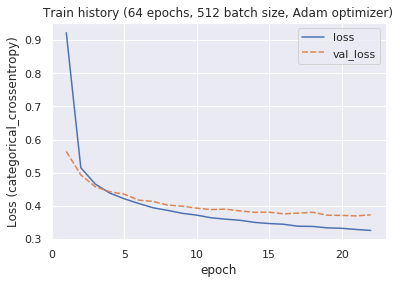

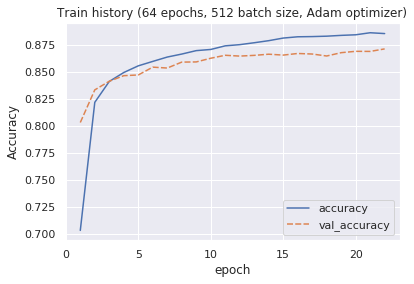

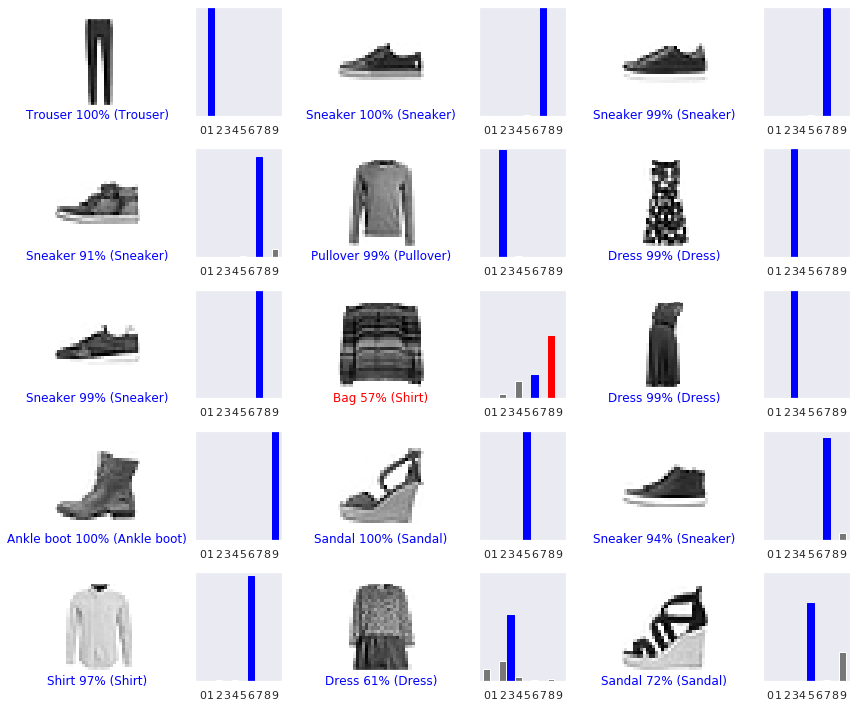

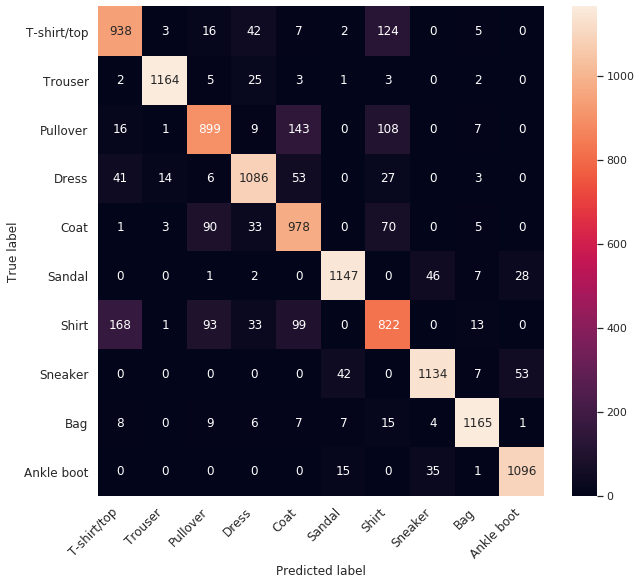

In [69]:
Y_val_80var_pred = train_pca_model(model_80var, pca_80var)

In [70]:
print_f1_scores(ys_val, np.argmax(Y_val_80var_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.7990  |  0.8250  |  0.8118
Class 1 (Trouser):       0.9815  |  0.9660  |  0.9737
Class 2 (Pullover):      0.8034  |  0.7599  |  0.7811
Class 3 (Dress):         0.8786  |  0.8829  |  0.8808
Class 4 (Coat):          0.7581  |  0.8288  |  0.7919
Class 5 (Sandal):        0.9448  |  0.9318  |  0.9382
Class 6 (Shirt):         0.7032  |  0.6688  |  0.6856
Class 7 (Sneaker):       0.9303  |  0.9175  |  0.9238
Class 8 (Bag):           0.9588  |  0.9534  |  0.9561
Class 9 (Ankle boot):    0.9304  |  0.9555  |  0.9428

Combined F1 score:  0.8583
Combined Precision: 0.8587
Combined Recall:    0.8579


### 2.4.2. 60% explained variance

In [71]:
model_60var, pca_60var = build_pca_model(min_explained_variance=0.60, model_name="MLP_60var")

PCA(copy=True, iterated_power='auto', n_components=0.6, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

5 principal components → 0.6156876087188721 explained variance
5 / 784 = 0.64% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 26us/sample - loss: 1.0184 - accuracy: 0.6362 - val_loss: 0.7802 - val_accuracy: 0.7092
Epoch 2/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.7556 - accuracy: 0.7164 - val_loss: 0.7355 - val_accuracy: 0.7189
Epoch 3/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.7252 - accuracy: 0.7248 - val_loss: 0.7192 - val_accuracy: 0.7278
Epoch 4/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.7091 - accuracy: 0.7313 - val_loss: 0.7019 - val_accuracy: 0.7327
Epoch 5/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.7009 - accuracy: 0.7342 - val_loss: 0.6985 - val_accuracy: 0.7333
Epoch 6/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.6921 - accuracy: 0.7366 - val_loss: 0.6882 - val_accuracy: 0.7373
Epoch 7/64
48000/48000 [===========

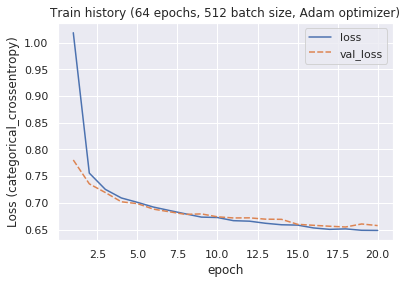

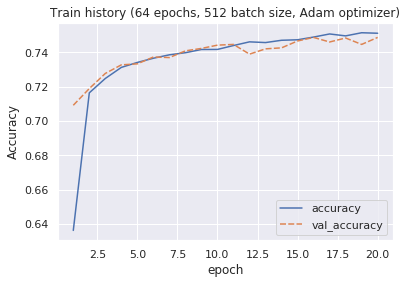

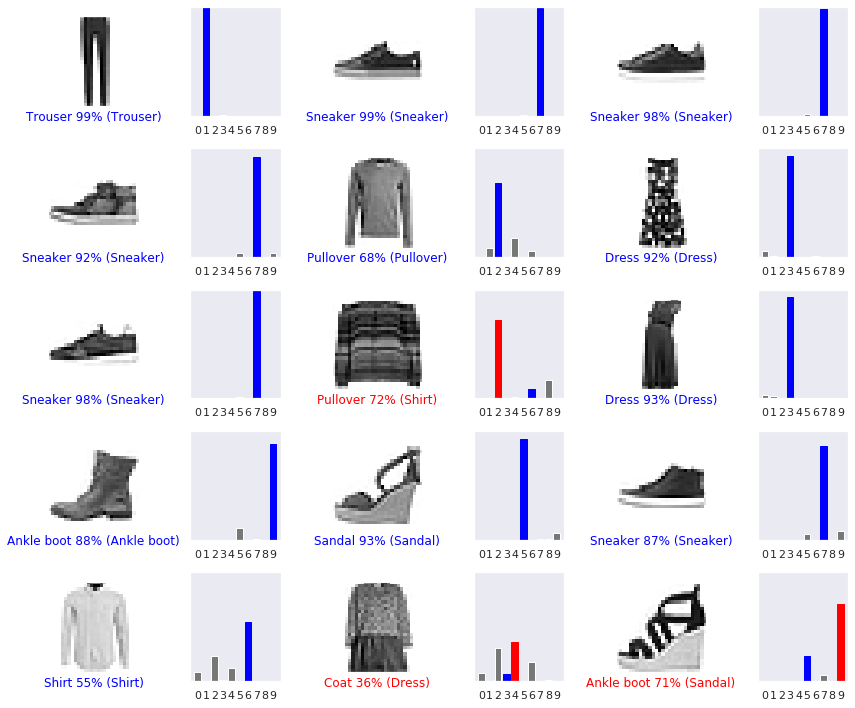

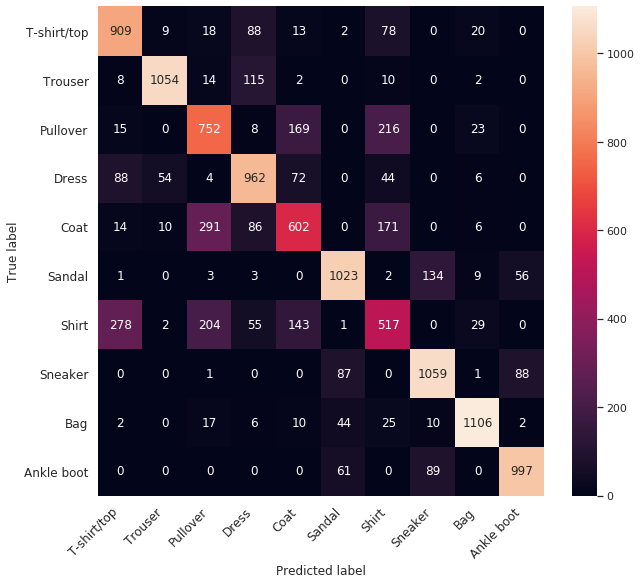

In [72]:
Y_val_60var_pred = train_pca_model(model_60var, pca_60var)

In [73]:
# 60% explained variance
print_f1_scores(ys_val, np.argmax(Y_val_60var_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.6913  |  0.7995  |  0.7414
Class 1 (Trouser):       0.9336  |  0.8747  |  0.9032
Class 2 (Pullover):      0.5767  |  0.6357  |  0.6047
Class 3 (Dress):         0.7271  |  0.7821  |  0.7536
Class 4 (Coat):          0.5955  |  0.5102  |  0.5495
Class 5 (Sandal):        0.8399  |  0.8310  |  0.8354
Class 6 (Shirt):         0.4864  |  0.4207  |  0.4511
Class 7 (Sneaker):       0.8197  |  0.8568  |  0.8378
Class 8 (Bag):           0.9201  |  0.9051  |  0.9125
Class 9 (Ankle boot):    0.8723  |  0.8692  |  0.8707

Combined F1 score:  0.7088
Combined Precision: 0.7140
Combined Recall:    0.7038


### 2.5. Plot the first principal components

Out of curiosity, let's visualize the first 2 and 3 components.

In [0]:
pca_3pc = PCA(n_components=3)

In [0]:
pca_3pc_result = pca_3pc.fit_transform(X_train)

In [76]:
print(f"Explained variance per principal component:")
for i, (var, cumsum) in enumerate(zip(pca_3pc.explained_variance_ratio_, np.cumsum(pca_3pc.explained_variance_ratio_))):
    print(f"PC {i+1}: {var:.4f} (cumulative sum: {cumsum:.2f})")

Explained variance per principal component:
PC 1: 0.2896 (cumulative sum: 0.29)
PC 2: 0.1775 (cumulative sum: 0.47)
PC 3: 0.0606 (cumulative sum: 0.53)


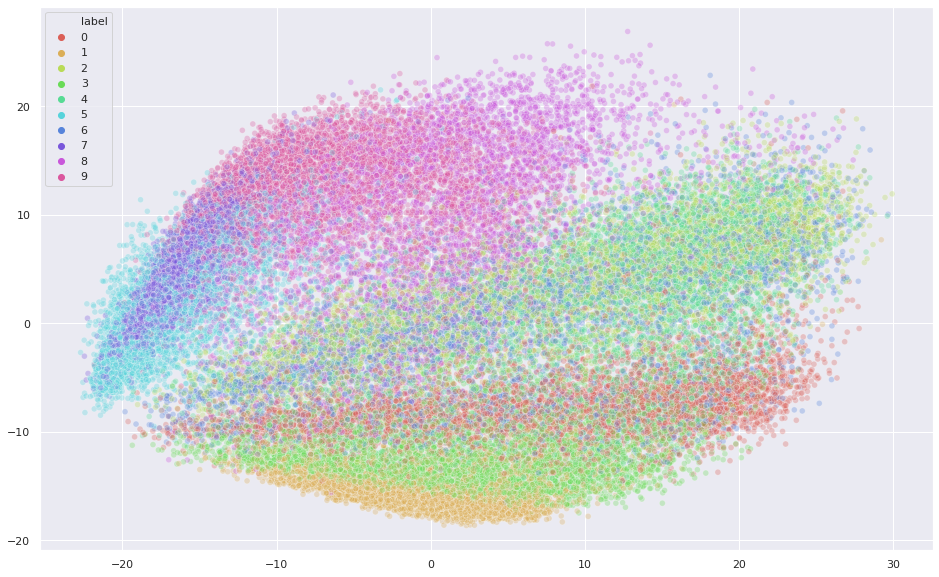

In [77]:
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x=pca_3pc_result[..., 0], # PC 1
    y=pca_3pc_result[..., 1], # PC 2
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=train_dataset,
    legend="full",
    alpha=0.3
)

In [0]:
from mpl_toolkits.mplot3d import Axes3D

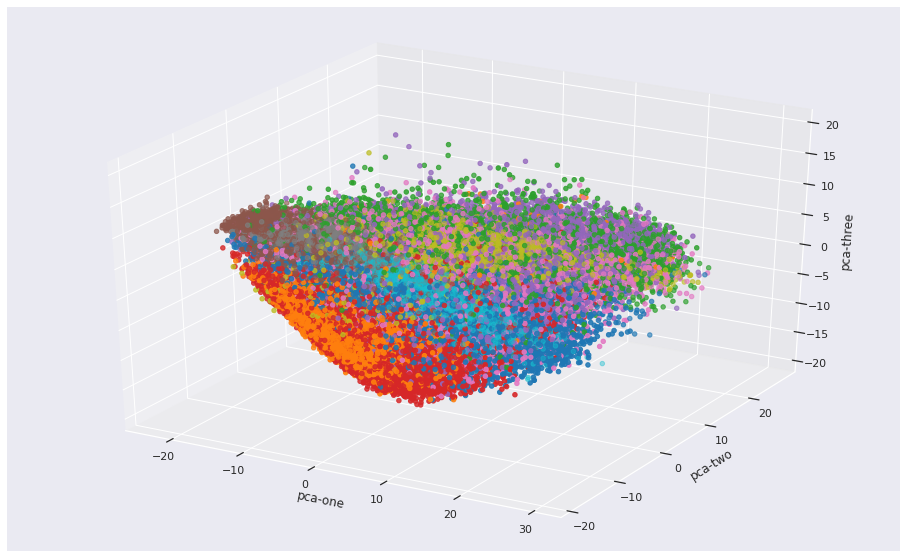

In [79]:
# run '%matplotlib notebook' for an interactive (but laggy) visualization
ax = plt.figure(figsize=(16, 10)).gca(projection='3d')
ax.scatter(
    xs=pca_3pc_result[..., 0], # PC 1
    ys=pca_3pc_result[..., 1], # PC 2
    zs=pca_3pc_result[..., 2], # PC 3
    c=ys_train, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## 3. Using Autoencoders
Re-do the ﬁrst experiment considering Autoencoders for reducing the image dimensionality. Consider two diﬀerent latent vector size for reducing the image dimensionality. What are the conclusions when using Autoencoders in this problem? Does accuracy improve?

Autoencoders are a branch of neural network which attempt to compress the information of the input variables into a reduced dimensional space and then recreate the input data set. Typically the autoencoder is trained over a number of iterations using gradient descent, minimizing the mean squared error. The key component is the “bottleneck” hidden layer. This is where the information from the input has been compressed. By extracting this layer from the model, each node can now be treated as a variable in the same way each chosen principal component is used as a variable in following models.


In [0]:
from tensorflow.keras import Model
# ref.: https://blog.keras.io/building-autoencoders-in-keras.html
#       https://www.tensorflow.org/tutorials/generative/cvae

In [0]:
def build_autoencoder(latent_dim):
    __input   = Input(shape=(784,)) # 28 * 28 = 784 pixels
    __encoded = Dense(latent_dim, activation='relu', activity_regularizer=l1(1e-4))(__input)
    __decoded = Dense(784, activation='sigmoid')(__encoded)

    autoencoder = Model(__input, __decoded)
    print("\nAutoencoder summary:")
    print(autoencoder.summary())

    encoder = Model(__input, __encoded)
    print("\nEncoder summary:")
    print(encoder.summary())

    # create a placeholder for an encoded (24-dimensional) input
    encoded_input = Input(shape=(latent_dim,))
    # retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-1]

    decoder = Model(encoded_input, decoder_layer(encoded_input))
    print("\nDecoder summary:")
    print(decoder.summary())

    autoencoder.compile(optimizer='adam', loss='mse')

    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.003, patience=3)]

    autoencoder.fit(X_train, X_train,
                    validation_data=(X_val, X_val),
                    epochs=MAX_EPOCHS,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    callbacks=callbacks,
                    verbose=TF_VERBOSE)
    return autoencoder, encoder, decoder

In [0]:
def show_autoencoder_samples(encoder, decoder):
    encoded_imgs = encoder.predict(X_val)
    decoded_imgs = decoder.predict(encoded_imgs)

    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(X_val[i].reshape(28, 28), cmap='binary')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='binary')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [0]:
def train_ae_model(encoder, latent_dim, model_name):
    model = keras.Sequential([
        Input(shape=(latent_dim, )), # number of components used to keep min_explained_variance
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
    ], model_name)

    model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

    history_ae, best_model_ae = train(model, 
                                      encoder.predict(X_train), Y_train, 
                                      encoder.predict(X_val), Y_val)

    # using ys_val below, instead of np.argmax(Y_val, axis=1), simply for convinence

    Y_val_ae_pred = best_model_ae.predict(encoder.predict(X_val))
    plot_image_with_prediction(X_val, ys_val, Y_val_ae_pred)

    print_cm(ys_val, np.argmax(Y_val_ae_pred, axis=1), CLASS_NAME)
    
    return Y_val_ae_pred, best_model_ae

### 3.1. Latent vector size of 84

In [0]:
latent_dim = 84

In [85]:
autoencoder_84, encoder_84, decoder_84 = build_autoencoder(latent_dim)


Autoencoder summary:
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_19 (Dense)             (None, 84)                65940     
_________________________________________________________________
dense_20 (Dense)             (None, 784)               66640     
Total params: 132,580
Trainable params: 132,580
Non-trainable params: 0
_________________________________________________________________
None

Encoder summary:
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_19 (Dense)             (None, 84)                6594

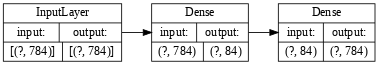

In [128]:
tf.keras.utils.plot_model(autoencoder_84, show_shapes=True, show_layer_names=False, rankdir='LR', dpi=60)

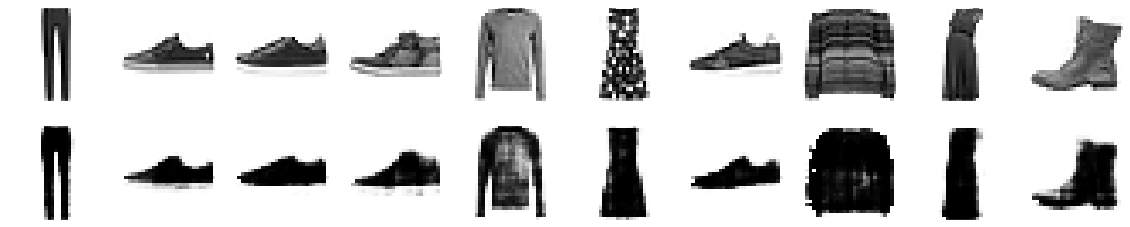

In [86]:
show_autoencoder_samples(encoder_84, decoder_84)

Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 22us/sample - loss: 0.9485 - accuracy: 0.6998 - val_loss: 0.5318 - val_accuracy: 0.8181
Epoch 2/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.4885 - accuracy: 0.8326 - val_loss: 0.4634 - val_accuracy: 0.8405
Epoch 3/64
48000/48000 [==============================] - 1s 10us/sample - loss: 0.4360 - accuracy: 0.8506 - val_loss: 0.4298 - val_accuracy: 0.8518
Epoch 4/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.4069 - accuracy: 0.8610 - val_loss: 0.4183 - val_accuracy: 0.8538
Epoch 5/64
48000/48000 [==============================] - 1s 10us/sample - loss: 0.3858 - accuracy: 0.8676 - val_loss: 0.4065 - val_accuracy: 0.8575
Epoch 6/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.3683 - accuracy: 0.8733 - val_loss: 0.3996 - val_accuracy: 0.8594
Epoch 7/64
48000/48000 [===========

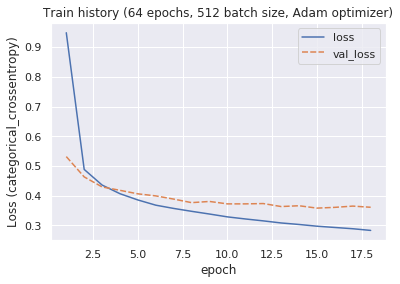

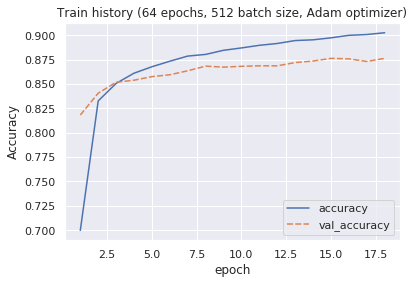

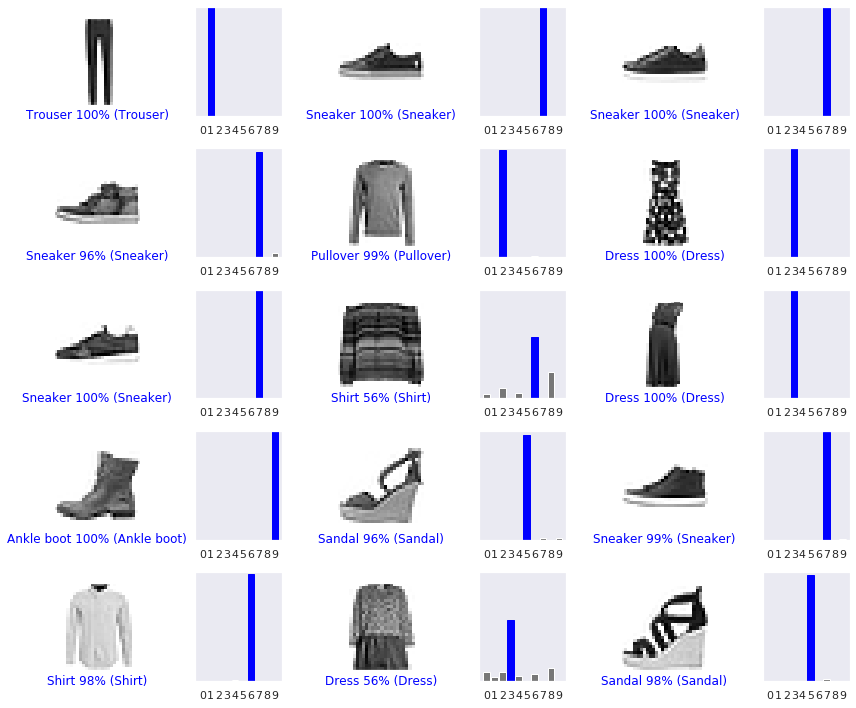

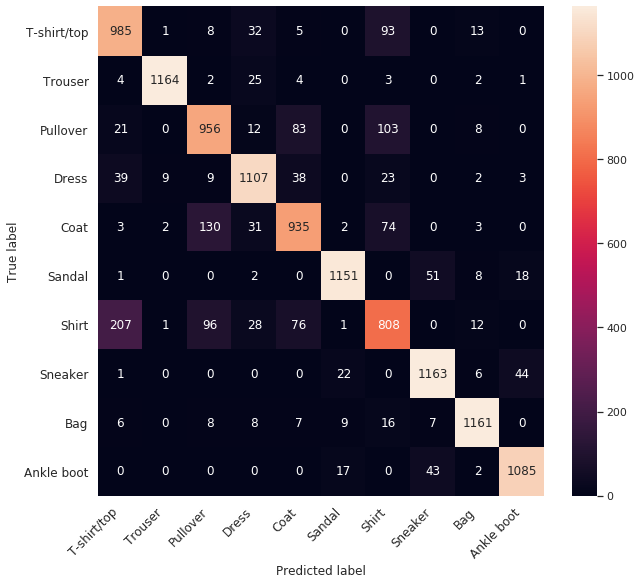

In [87]:
Y_val_ae_84_pred, model_ae_84 = train_ae_model(encoder_84, latent_dim, model_name="AE_84")

In [88]:
print_f1_scores(ys_val, np.argmax(Y_val_ae_84_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.7774  |  0.8663  |  0.8195
Class 1 (Trouser):       0.9890  |  0.9660  |  0.9773
Class 2 (Pullover):      0.7907  |  0.8081  |  0.7993
Class 3 (Dress):         0.8892  |  0.9000  |  0.8945
Class 4 (Coat):          0.8145  |  0.7924  |  0.8033
Class 5 (Sandal):        0.9576  |  0.9350  |  0.9462
Class 6 (Shirt):         0.7214  |  0.6574  |  0.6880
Class 7 (Sneaker):       0.9201  |  0.9409  |  0.9304
Class 8 (Bag):           0.9540  |  0.9501  |  0.9520
Class 9 (Ankle boot):    0.9427  |  0.9459  |  0.9443

Combined F1 score:  0.8656
Combined Precision: 0.8665
Combined Recall:    0.8648


### 3.2. Latent vector size of 24

In [0]:
latent_dim = 24

In [90]:
autoencoder_24, encoder_24, decoder_24 = build_autoencoder(latent_dim)


Autoencoder summary:
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_24 (Dense)             (None, 24)                18840     
_________________________________________________________________
dense_25 (Dense)             (None, 784)               19600     
Total params: 38,440
Trainable params: 38,440
Non-trainable params: 0
_________________________________________________________________
None

Encoder summary:
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_24 (Dense)             (None, 24)                1884

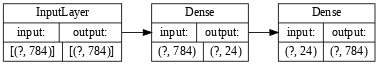

In [129]:
tf.keras.utils.plot_model(autoencoder_24, show_shapes=True, show_layer_names=False, rankdir='LR', dpi=60)

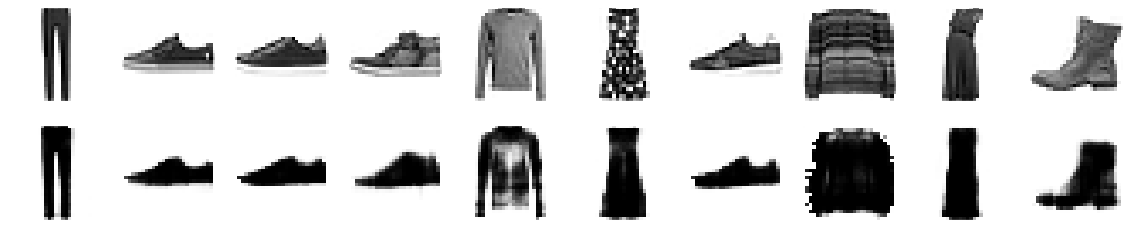

In [91]:
show_autoencoder_samples(encoder_24, decoder_24)

Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 22us/sample - loss: 0.9183 - accuracy: 0.7047 - val_loss: 0.5609 - val_accuracy: 0.8017
Epoch 2/64
48000/48000 [==============================] - 1s 10us/sample - loss: 0.5197 - accuracy: 0.8168 - val_loss: 0.4980 - val_accuracy: 0.8223
Epoch 3/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.4756 - accuracy: 0.8332 - val_loss: 0.4706 - val_accuracy: 0.8331
Epoch 4/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.4510 - accuracy: 0.8413 - val_loss: 0.4594 - val_accuracy: 0.8367
Epoch 5/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.4342 - accuracy: 0.8484 - val_loss: 0.4455 - val_accuracy: 0.8388
Epoch 6/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.4229 - accuracy: 0.8505 - val_loss: 0.4346 - val_accuracy: 0.8447
Epoch 7/64
48000/48000 [===========

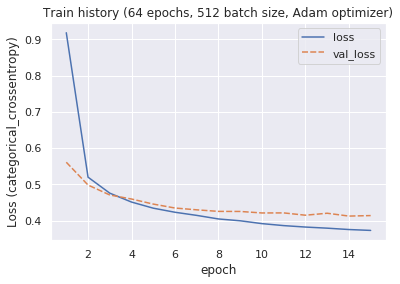

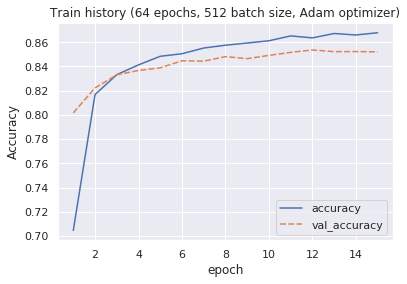

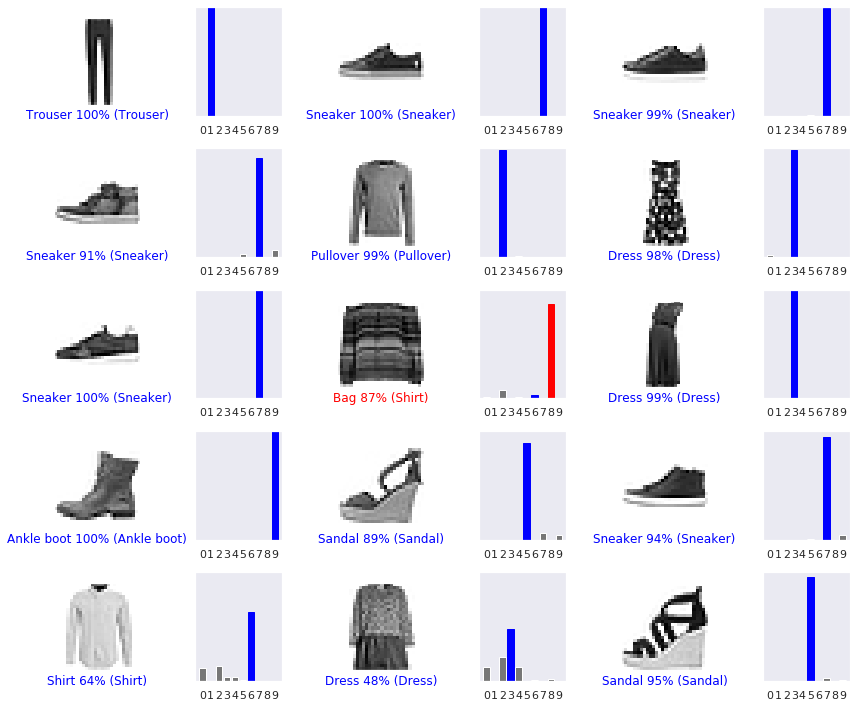

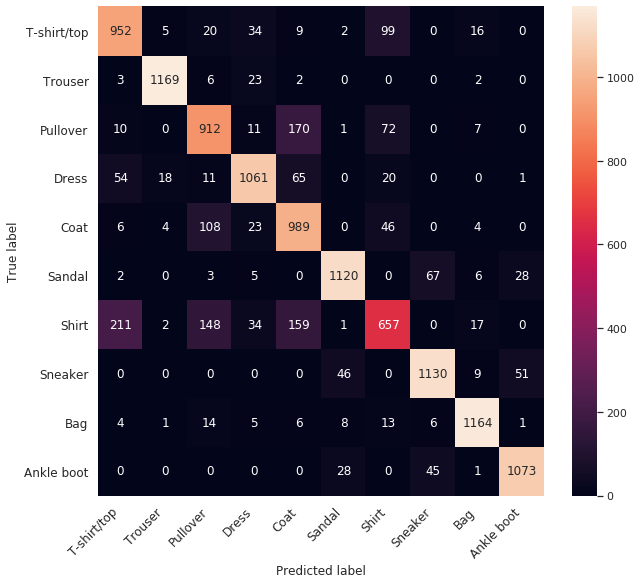

In [92]:
Y_val_ae_24_pred, model_ae_24 = train_ae_model(encoder_24, latent_dim, model_name="AE_24")

In [93]:
print_f1_scores(ys_val, np.argmax(Y_val_ae_24_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.7665  |  0.8373  |  0.8003
Class 1 (Trouser):       0.9750  |  0.9701  |  0.9725
Class 2 (Pullover):      0.7463  |  0.7709  |  0.7584
Class 3 (Dress):         0.8871  |  0.8626  |  0.8747
Class 4 (Coat):          0.7064  |  0.8381  |  0.7667
Class 5 (Sandal):        0.9287  |  0.9098  |  0.9192
Class 6 (Shirt):         0.7244  |  0.5346  |  0.6152
Class 7 (Sneaker):       0.9054  |  0.9142  |  0.9098
Class 8 (Bag):           0.9494  |  0.9525  |  0.9510
Class 9 (Ankle boot):    0.9298  |  0.9355  |  0.9326

Combined F1 score:  0.8347
Combined Precision: 0.8401
Combined Recall:    0.8294


## 4. Using clustering techniques
Explore two clustering algorithms using the reduced features (PCA or Autoencoders). Do the clusters make sense? Check the validity/quality of your clusters.

In [0]:
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score

In [0]:
def show_clusters(clusters, data):
    print("Clusters:", set(clusters.labels_))

    # [-1.0, 1.0], with 1.0 being the perfect score, and 0.0 being random
    print("Adjusted Rand Score:", adjusted_rand_score(ys_val, clusters.labels_))
    # (-inf, 1.0], with 1.0 being the perfect score, and 0.0 being random
    print("Adjusted Mutual Information Score:", adjusted_mutual_info_score(ys_val, clusters.labels_))
    # [-1.0, 1.0], with 1.0 for highly dense clustering, 0.0 indicate overlapping clusters, and -1.0 for incorrect clustering
    print("Silhouette Coefficient:", silhouette_score(data, clusters.labels_))

    labels = clusters.labels_.astype(float)
    # we select the first two feature columns for plotting in 2D
    __xs, __ys = data[..., 0], data[..., 1]

    try:
        centroids = clusters.cluster_centers_ # K-Means
        __xc, __yc = centroids[..., 0], centroids[..., 1]
    except:
        centroids = None

    # plt.scatter(x=__xs, y=__ys, c=labels, s=50, alpha=0.8, cmap="viridis")
    # plt.scatter(__xc, __yc, marker='+', s=169, linewidths=3, color='red', zorder=10)
    
    plt.figure(figsize=(16, 10))
    sns.scatterplot(x=__xs, y=__ys, 
                    hue=labels, palette=sns.color_palette("hls", 10), legend="full", alpha=0.3)
    if centroids is not None:
        sns.scatterplot(x=__xc, y=__yc, 
                        marker='+', s=175, linewidths=3, color='black', zorder=10)
    plt.show()

Let's standardize the features we'll be using for clustering with Z-score:

In [96]:
reduced_features_list = [("X_val_80var", pca_80var.transform(X_val)), ("X_val_90var", pca_90var.transform(X_val))]
                      # [("X_val_ae_24", encoder_24.predict(X_val)), ("X_val_ae_84", encoder_84.predict(X_val))]
reduced_features_zscore = []
for name, reduced_features in reduced_features_list:
    print(f"{name+':':<19} {str(reduced_features.shape):<11} "
          f"| min: {reduced_features.min():>6.2f} | max: {reduced_features.max():>6.2f} "
          f"| mean: {reduced_features.mean():>6.3f} | std: {reduced_features.std():>6.3f}")
    reduced_features_zscore.append((name + "_zscore", (reduced_features - reduced_features.mean()) / reduced_features.std()))
for name, reduced_features in reduced_features_zscore:
    print(f"{name+':':<19} {str(reduced_features.shape):<11} "
          f"| min: {reduced_features.min():>6.2f} | max: {reduced_features.max():>6.2f} "
          f"| mean: {reduced_features.mean():>6.3f} | std: {reduced_features.std():>6.3f}")

X_val_80var:        (12000, 24) | min: -22.32 | max:  30.72 | mean: -0.003 | std:  4.271
X_val_90var:        (12000, 84) | min: -22.32 | max:  30.72 | mean: -0.001 | std:  2.421
X_val_80var_zscore: (12000, 24) | min:  -5.23 | max:   7.19 | mean:  0.000 | std:  1.000
X_val_90var_zscore: (12000, 84) | min:  -9.22 | max:  12.69 | mean:  0.000 | std:  1.000


## 4.1. Mini-Batch K-Means

Using X_val_80var_zscore:
Clusters: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Adjusted Rand Score: 0.34174689879339704
Adjusted Mutual Information Score: 0.49920925737008054


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


Silhouette Coefficient: 0.21468213


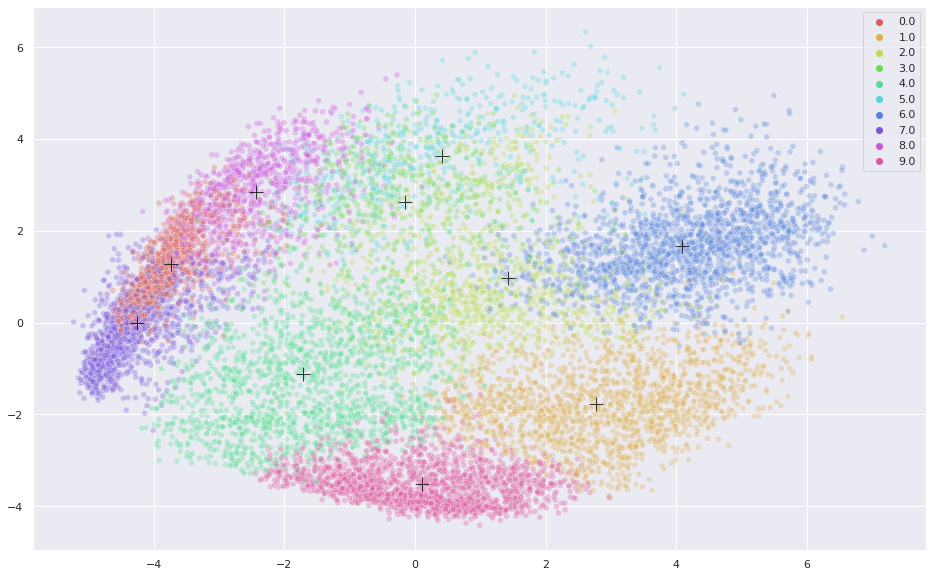

Using X_val_90var_zscore:
Clusters: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Adjusted Rand Score: 0.3753633171583936
Adjusted Mutual Information Score: 0.5208375761669055


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


Silhouette Coefficient: 0.17939368


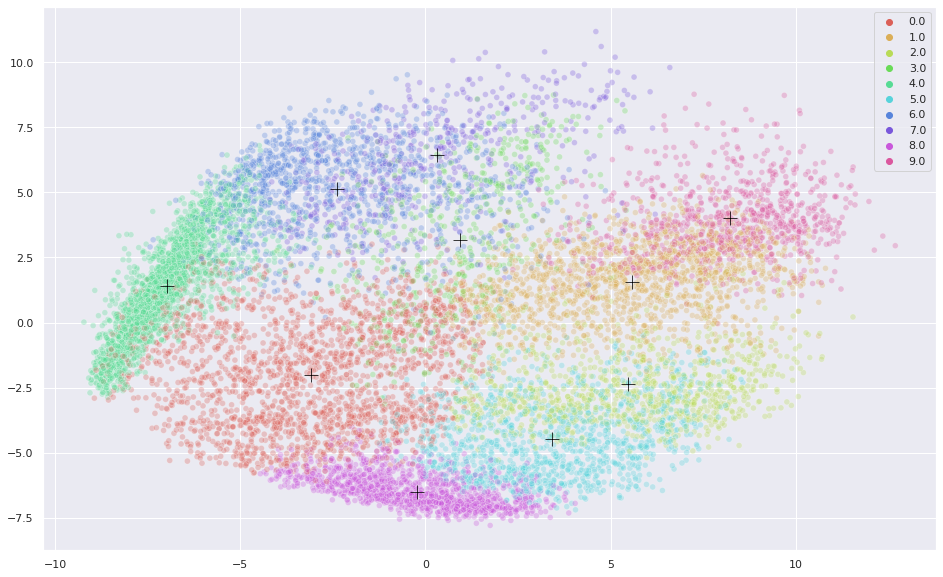

In [132]:
for name, reduced_features in reduced_features_zscore:
    print(f"Using {name}:")
    mbkmeans = MiniBatchKMeans(n_clusters=10).fit(reduced_features)
    show_clusters(mbkmeans, reduced_features)

## 4.2. K-Means

Using X_val_80var_zscore:
Clusters: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Adjusted Rand Score: 0.3457443698539012
Adjusted Mutual Information Score: 0.49656078363852746


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


Silhouette Coefficient: 0.23645043


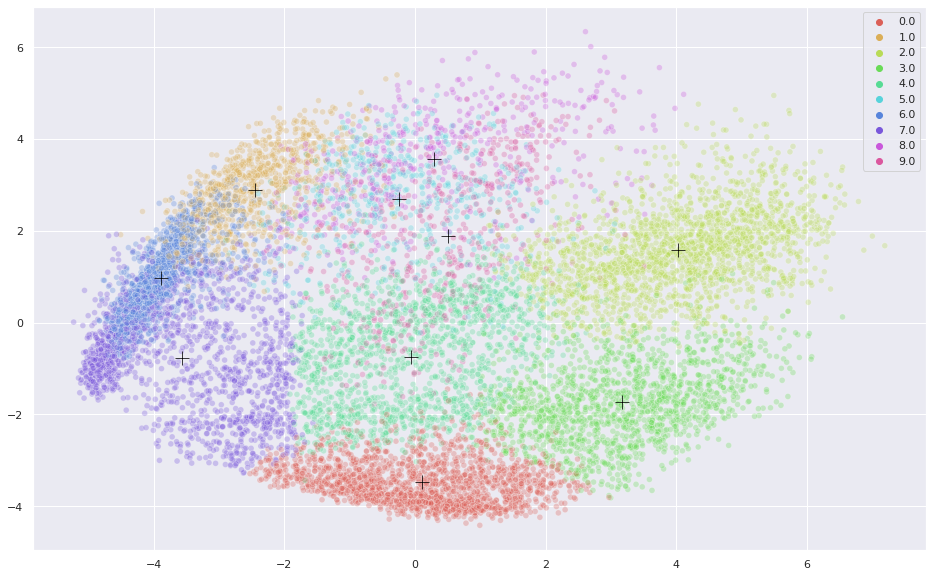

Using X_val_90var_zscore:
Clusters: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Adjusted Rand Score: 0.3849883403189506
Adjusted Mutual Information Score: 0.5188173816541691


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


Silhouette Coefficient: 0.18233255


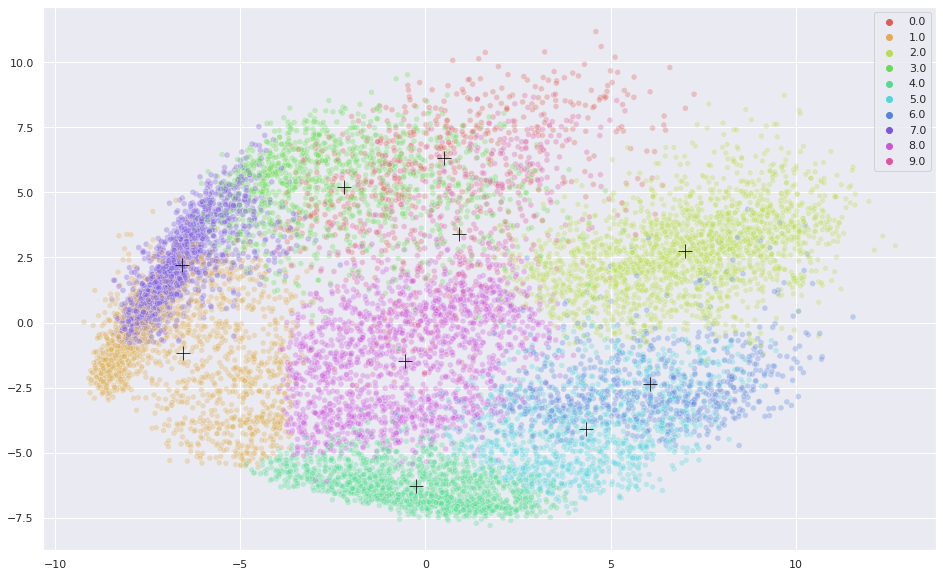

In [133]:
for name, reduced_features in reduced_features_zscore:
    print(f"Using {name}:")
    kmeans = KMeans(n_clusters=10).fit(reduced_features)
    show_clusters(kmeans, reduced_features)

### 4.2.1. Autoencoder reduced features (24 latent vector size)

In [0]:
# kmeans_ae_24 = KMeans(n_clusters=10).fit(X_val_ae_24)
# show_clusters(kmeans_ae_24, X_val_ae_24)

### 4.2.2. Autoencoder reduced features (84 latent vector size)

In [0]:
# kmeans_ae_84 = KMeans(n_clusters=10).fit(X_val_ae_84)
# show_clusters(kmeans_ae_84, X_val_ae_84)

### 4.2.3. PCA reduced features (80% explained variance, 24 principal components)

In [0]:
# kmeans_pca_80var = KMeans(n_clusters=10).fit(X_val_80var)
# show_clusters(kmeans_pca_80var, X_val_80var)

### 4.2.4. PCA reduced features (90% explained variance, 84 principal components)

In [0]:
# kmeans_pca_90var = KMeans(n_clusters=10).fit(X_val_90var)
# show_clusters(kmeans_pca_90var, X_val_90var)

## 4.3. Agglomerative clustering

Using X_val_80var_zscore:
Clusters: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Adjusted Rand Score: 0.3829911713629829
Adjusted Mutual Information Score: 0.5343160566868098


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


Silhouette Coefficient: 0.18349311


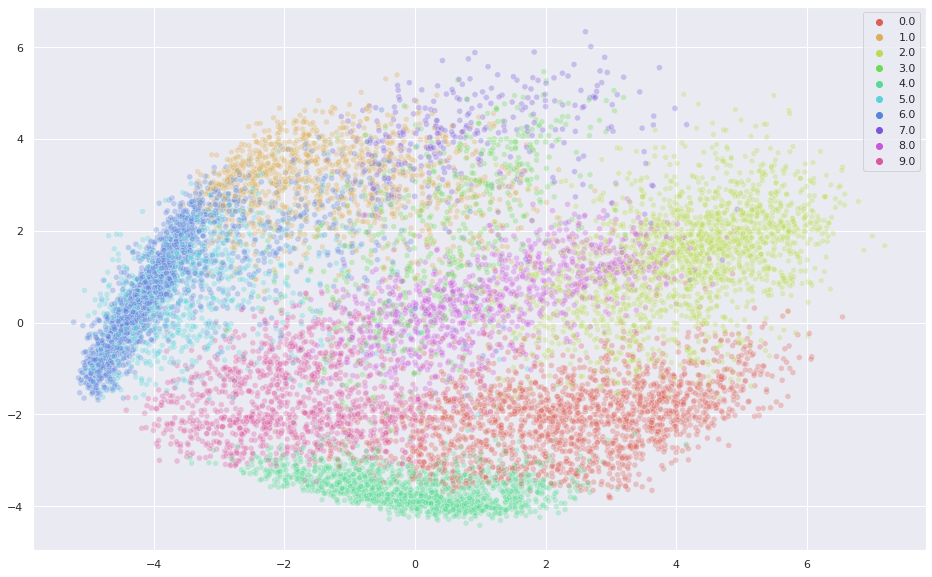

Using X_val_90var_zscore:
Clusters: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Adjusted Rand Score: 0.3420215460321087
Adjusted Mutual Information Score: 0.48548545423026795


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


Silhouette Coefficient: 0.14761758


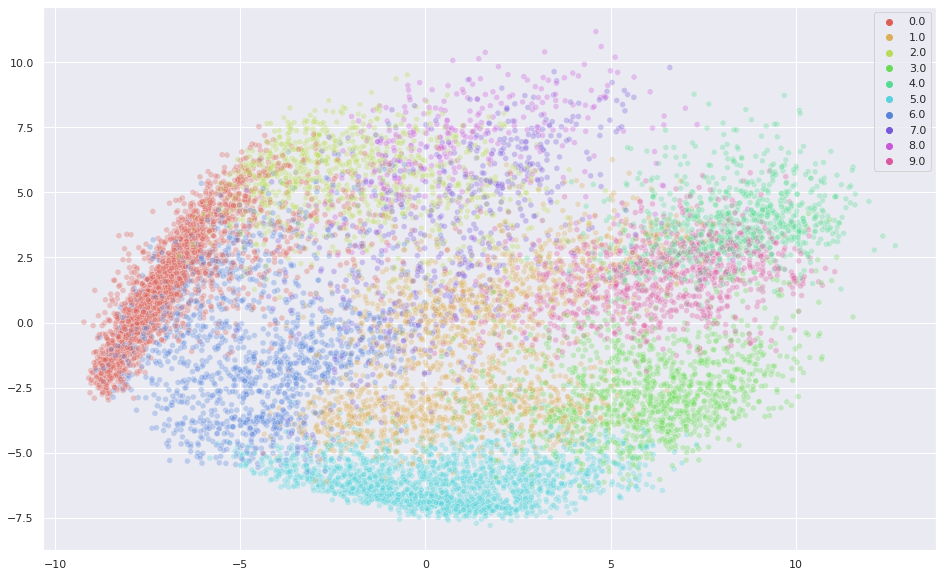

In [138]:
for name, reduced_features in reduced_features_zscore:
    print(f"Using {name}:")
    agglomerative = AgglomerativeClustering(n_clusters=10).fit(reduced_features)
    show_clusters(agglomerative, reduced_features)

### 4.2.1. PCA reduced features (80% explained variance, 24 principal components)

In [0]:
# agglomerative_pca_80var = AgglomerativeClustering(n_clusters=10).fit(X_val_80var)
# show_clusters(agglomerative_pca_80var, X_val_80var)

### 4.2.2. PCA reduced features (90% explained variance, 84 principal components)

In [0]:
# agglomerative_pca_90var = AgglomerativeClustering(n_clusters=10).fit(X_val_90var)
# show_clusters(agglomerative_pca_80var, X_val_90var)

In [141]:
strftime('%X')

'15:34:59'